In [4]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


#Create a pandas DataFrame for the counts data set.
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

#We'll add a few derived regression variables to the X matrix.
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

#Let's print out the first few rows of our data set to see how it looks like
print(df.head(10))

#Let's create the training and testing data sets.
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#Setup the regression expression in Patsy notation.
#We are telling patsy that BB_COUNT is our dependent variable y and it depends on the regression variables X:
#DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.
expr = 'BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP'

#Let's use Patsy to carve out the X and y matrices for the training and testing data sets:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

print(X_train)

            HIGH_T  LOW_T  PRECIP  BB_COUNT  MONTH  DAY_OF_WEEK  DAY
Date                                                                
2017-04-01    46.0   37.0    0.00       606      4            5    1
2017-04-02    62.1   41.0    0.00      2021      4            6    2
2017-04-03    63.0   50.0    0.03      2470      4            0    3
2017-04-04    51.1   46.0    1.18       723      4            1    4
2017-04-05    63.0   46.0    0.00      2807      4            2    5
2017-04-06    48.9   41.0    0.73       461      4            3    6
2017-04-07    48.0   43.0    0.01      1222      4            4    7
2017-04-08    55.9   39.9    0.00      1674      4            5    8
2017-04-09    66.0   45.0    0.00      2375      4            6    9
2017-04-10    73.9   55.0    0.00      3324      4            0   10
Training data set length=157
Testing data set length=57
            Intercept   DAY  DAY_OF_WEEK  MONTH  HIGH_T  LOW_T  PRECIP
Date                                         

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:                            GLM   Df Residuals:                      165
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12218.
Date:                Wed, 14 Apr 2021   Deviance:                       22779.
Time:                        12:22:45   Pearson chi2:                 2.29e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0453      0.013    560.323      

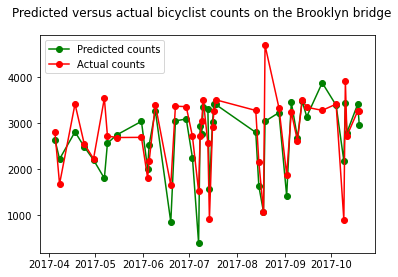

Optimization terminated successfully.
         Current function value: 8.213959
         Iterations: 27
         Function evaluations: 105
         Gradient evaluations: 103
                    GeneralizedPoisson Regression Results                     
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:             GeneralizedPoisson   Df Residuals:                      165
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Apr 2021   Pseudo R-squ.:                 0.04681
Time:                        12:22:45   Log-Likelihood:                -1412.8
converged:                       True   LL-Null:                       -1482.2
Covariance Type:            nonrobust   LLR p-value:                 1.838e-27
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.3499      0.210 

In [2]:

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

#Let's print out the variance and mean of the data set
print('variance='+str(df['BB_COUNT'].var()))
print('mean='+str(df['BB_COUNT'].mean()))

#Build Consul's Generalized Poison regression model, know as GP-1
gen_poisson_gp1 = sm.GeneralizedPoisson(y_train, X_train, p=1)

#Fit the model
gen_poisson_gp1_results = gen_poisson_gp1.fit()

#print the results
print(gen_poisson_gp1_results.summary())

#Get the model's predictions on the test data set
gen_poisson_gp1_predictions = gen_poisson_gp1_results.predict(X_test)

predicted_counts=gen_poisson_gp1_predictions
actual_counts = y_test['BB_COUNT']

fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y_train, X_train, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit()

#print the results
print(gen_poisson_gp2_results.summary())